In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm

import os, sys
import warnings
warnings.filterwarnings('ignore')
# import my own modules
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_mtm_pnl, generate_pnl_index, generate_exposures 
from Preprocessing.labeling import get_t1, _apply_pt_sl
from Preprocessing.sampling import get_events_avg_uniqueness, _get_num_concurrent_events, _get_average_uniqueness


In [2]:
events = pd.read_csv('C:/Users/Brendan/Downloads/auc.csv').sort_values('adate')
px_raw = pd.read_csv('C:/Users/Brendan/Downloads/otrpx.csv')
monthend = pd.read_csv('C:/Users/Brendan/Downloads/medates.csv').sort_values('date')


# Initial exploration

index counts: (US30I, 2016-12-02 00:00:00)    1
(US10I, 2010-02-09 00:00:00)    1
(US10N, 2019-07-11 00:00:00)    1
(US2N, 2013-05-14 00:00:00)     1
(US10I, 2013-12-04 00:00:00)    1
(US5N, 2020-01-02 00:00:00)     1
(US30N, 2015-11-30 00:00:00)    1
(US5N, 2014-08-26 00:00:00)     1
(US3N, 2016-04-19 00:00:00)     1
(US30I, 2009-01-29 00:00:00)    1
dtype: int64
anything less than 0? ticker
US10I     True
US10N    False
US20N    False
US2N     False
US30I     True
US30N    False
US3N     False
US5I      True
US5N     False
US7N     False
dtype: bool
dimensions: (3579, 10)


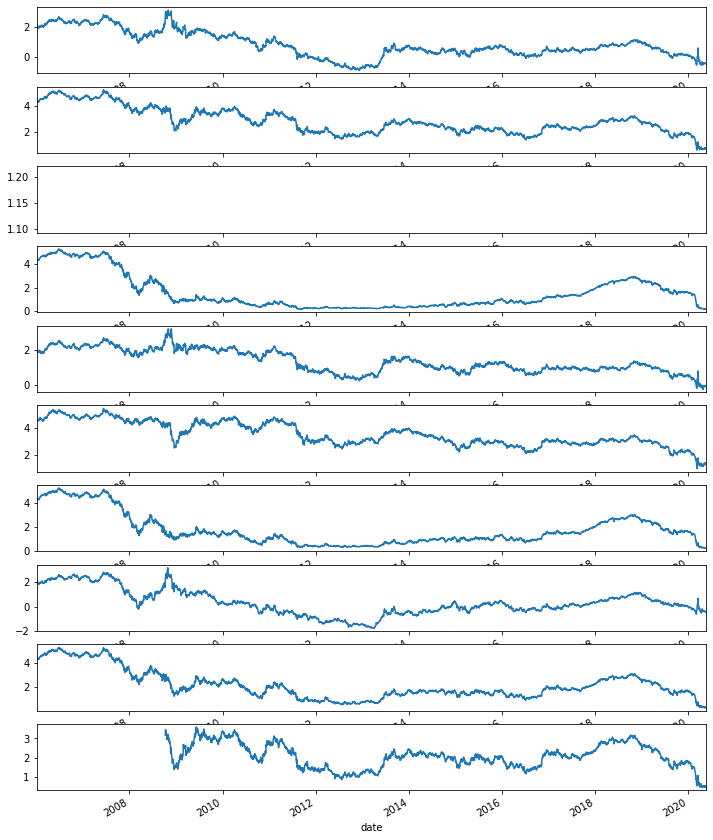

In [3]:
events = events[['ticker','adate','ayld','bid_to_cover','tail']]
monthend['adate'] = pd.to_datetime(monthend['date'].values)
events['adate'] = pd.to_datetime(events['adate'].values)
events['month'] = events['adate'].apply(lambda x: x.strftime('%Y-%m'))
px_raw['date'] = pd.to_datetime(px_raw['date'].values)

monthend['ticker'] = 'ME'
monthend['ayld'] = np.nan
monthend = monthend[['ticker','adate','ayld','month']]
events = events.append(monthend)
events = events.astype({'ticker':str, 'ayld':float})

px_raw = px_raw[['ticker','date','bbgyld']]
master_index = pd.Series(px_raw['date'].unique())

#scrub
px = px_raw.set_index(['ticker','date'])
print('index counts:', px.index.value_counts().head(10))
px = px[~px.index.duplicated(keep='first')] #drop duplicates
px = px.unstack(level=0)

#take a look
px.columns = px.columns.droplevel(0)
print('anything less than 0?', px[px<0].any()) #log returns will fail

print('dimensions:', px.shape)
fig, ax = plt.subplots(figsize=(12,16), nrows=px.shape[1])
for i, col in enumerate(px.columns):
    px[col].plot(ax=ax[i])
plt.show()


In [4]:
# merge monthend dates to each auction event
events = events.merge(events[events['ticker']=='ME'].loc[:,['month','adate']],
                                              on='month',suffixes=('','_me'))

In [5]:
# create indicator matrix of events with full px index
events_ind = events[['ticker','adate']]
events_ind['ind'] = 1
events_ind = events_ind.pivot(index='adate',columns='ticker',values='ind')
events_ind = events_ind.reindex(px.index).reset_index()

# PCA

## Momentum Analysis

In [6]:
def gen_subseq_returns(px, signal, max_len=30):
    """
        Generate ('single contract') returns subsequent to signal firing to evaluate predictiveness
    
    :param px: (pd.Series) series of prices
    :param signal: (pd.Series) series of entry signals (-1,0,1)
    :param max_len: (int) max index lookahead
    
    :return: (pd.DataFrame) returns up to max_len (cols), per signal fire (index)
    """
    signal = signal[signal!=0]
    sub_rets = pd.DataFrame(index=signal.index, columns=np.arange(max_len+1))
    
    for t, sig in signal.iteritems():
        t1_idx = min(px.index.searchsorted(t)+max_len, len(px.index)-1) #end of analysis period
        t1 = px.index[t1_idx]
        px0 = px.loc[t]
        sub_px = px.loc[t:t1].values
        sub_ret_np = np.array(sig*(sub_px-px0))
        if (len(sub_px)<max_len+1):
            sub_ret_np = np.hstack((sub_ret_np,sub_ret_np[-1]*np.ones(max_len+1-len(sub_px))))
        sub_rets.loc[t,:] = sub_ret_np
    
    if (sub_rets.shape[0]!=len(signal)): 
        raise ValueError('Num. of return subsets {0} not equal to num. signals given {1}!'.format(sub_rets.shape[0], 
                                                                                                  len(signal)))
    return sub_rets
    

def analyze_sub_rets(sub_rets, label, ax=None, subseq_days=[5,20,40], z_threshold=0):
    """
        Generate basic stats summary and plot avg subsequent return series
    
    :param sub_rets: (pd.DataFrame) subsequent returns (columns=days subseq.) per entry signal index
    :return: (pd.Series) summary statistics (and plot avg subsq return series)
    """
    
    avg_sub_rets = sub_rets.mean(axis=0)
    std_sub_rets = sub_rets.std(axis=0)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6), nrows=2, dpi=300)
    label_legend = str(label)+'-d lookback'
    avg_sub_rets.plot(ax=ax[0],label=label_legend)
    ax[0].set_title('Subsequent Return Avgs: '+str(np.round(z_threshold,2))+'-sigma Threshold')
    ann_ir = avg_sub_rets.divide(std_sub_rets)*np.sqrt(250/sub_rets.columns.values)
    ann_ir.plot(ax=ax[1], label=label_legend)
    ax[1].set_title('Subsequent Return Ann. IR*')
    
    # maybe use framework more in-depth
    stats = ['Mean', 'Std Dev', 'Ann. IR', 'Min','Max', 'Max DD', 'Num Obs', 'Hit Ratio']
    stats_arr = []
    for sp in subseq_days:
        sr = sub_rets.loc[:, sp]
        mean = sr.mean()
        stdev = sr.std()
        ann_ir = mean/stdev*np.sqrt(250/sp)
        mn = sr.min()
        mx = sr.max()
        max_dd = np.min(sub_rets.loc[:, np.arange(sp+1)].values)
        num_obs = len(sr)
        hit_ratio = len(sr[sr>0])/num_obs
        stats_srs = pd.Series([mean, stdev, ann_ir, mn, mx, max_dd, num_obs, hit_ratio], index=stats, name=sp)
        stats_arr.append(stats_srs)
    summary_df = pd.concat(stats_arr, axis=1).round(4)
    return summary_df


def gen_mom_signals(px, z_threshold=1., lookbacks=[1,3,5,10,30], zscore_lookback=25, signal_type='Momentum', center=False):
    """
        Generate series of signals (-1,0,1: short,none,long) based on zscore lookback returns
    
    :param px: (pd.Series) close prices
    :param lookbacks: (1d array) px change lookback timeframe array
    :param zscore_lookback: (int) rolling window length
    :param signal_type: (string) in ('Momentum', 'Reversion')
    :return: (pd.DataFrame) signals vector per lookback timeframe 
    """
    zscore_arr = []
    for lookback in lookbacks:
        zscore = lookback_zscore(px, lookback, zscore_lookback, log_ret=False, center=center)
        zscore_arr.append(zscore)
    # rolling (zscore_lookback) window zscores
    zscores = pd.concat(zscore_arr, axis=1)
    zscores.columns = lookbacks
    # dataframe of signals per lookback freq
    # uses function zscore_signal from my personal library also attached to submission
    signals = zscore_signal(zscores, z_threshold, signal_type)
    signals.columns = lookbacks
    
    return signals, zscores


def uniq_weighted_returns(px, signal, v, apply_side=False):
    """
        Generate return series of a simple indicator strategy adjusting for common return components
        (i.e. overlapping subsequent days from consecutive signal firing)
    :param px: (pd.Series) series of prices
    :param signal: (pd.Series) series of entry signals (-1,0,1)
    :param v: (int) end of signal in days (time stop-out)
    :return: uniqueness weighted v-period subsequent return series
    """
    signal = signal[signal!=0]
    t1 = get_t1(signal.index, px, vertbar=v).rename('t1')
    avg_uniq = get_events_avg_uniqueness(px, t1)
    
    wgt_rets = avg_uniq.join(signal.rename('side')).dropna()
    wgt_rets = wgt_rets.join(t1)
    wgt_rets['start_px'] = px.loc[wgt_rets.index].values
    wgt_rets['end_px'] = px.loc[wgt_rets.loc[:, 't1'].values].values
    wgt_rets['simple_ret'] = wgt_rets.loc[:, 'end_px']-wgt_rets.loc[:, 'start_px']
    wgt_rets['wgt_ret'] = wgt_rets.loc[:, 'simple_ret']*wgt_rets.loc[:, 'tw']
    if apply_side:
        wgt_rets.loc[:, 'wgt_ret'] = wgt_rets.loc[:, 'wgt_ret']*wgt_rets.loc[:, 'side']
    
    return wgt_rets


def get_pat_events(px, signal, v):
    """
        Generate single position series that averages active signals
    
    :param px: (pd.Series) series of prices
    :param signal: (pd.Series) series of entry signals (-1,0,1)
    :param v: (int) end of signal in days (time stop-out)
    :return: (pd.DataFrame) average signal frame, basic events srs
    """
    signal = signal[signal!=0]
    t1 = get_t1(signal.index, px, vertbar=v).rename('t1')
    events = t1.to_frame().merge(signal.rename('side'), how='left', left_index=True, right_index=True)
    
    # we want to weight each trade by the inverse of how many open trades there are over the holding period
    # this has the effect of keeping a live position equal to the average of each equally weighted signal
    num_concurrent = _get_num_concurrent_events(px.index, t1)
    events['size'] = _get_average_uniqueness(t1, num_concurrent)
    #will be our position time series
    out = pd.DataFrame(0, index=px.index, columns=['sum_position','count']) 
    
    for row in events.itertuples():
        out.loc[row.Index:row.t1, 'count'] += 1
        out.loc[row.Index:row.t1, 'sum_position'] += row.side
    
    out['position'] = out.loc[:, 'sum_position']/out.loc[:, 'count']
    return out, events


def generate_perf_summary(events, close_tr):
    """
    Function to generate CAGR, vol, sharpe, calmar, max drawdown, # trades, avg pnl per trade, hit ratio
    
    :input events: (pd.DataFrame) 'events' dataframe with t1, side, size, trgt
    :input close_tr: (pd.Series) total return series of underlying product
    :return: (pd.DataFrame) summary of pnl attributes
    """
    pnl = generate_mtm_pnl(events, close_tr, log_diff=False)
    pnl_index = generate_pnl_index(pnl)
    last_date = max(np.hstack((events['t1'].iloc[-1],pnl_index.index[-1])))
    years_live = (last_date-events.index[0])/252
    # since it's constant exposure, use simple average
    #cagr = np.power(pnl_index.iloc[-1]/pnl_index.iloc[0],1/years_live)-1.
    avg_ret = (pnl_index.iloc[-1]/pnl_index.iloc[0]-1)/years_live
    returns = pnl_index.diff(1).dropna()
    vol = returns.std()
    # assumes daily close data
    annualized_vol = vol*np.sqrt(252)
    sharpe = avg_ret/annualized_vol
    drawdown_pnl = pnl_index.subtract(pnl_index.expanding(0).max())
    max_dd = np.min(drawdown_pnl)
    calmar = -avg_ret/max_dd
    num_trades = events[abs(events['side'])>0].shape[0]
    avg_pnl = pnl.mean()
    #hit_ratio = events[events['side']==1].shape[0]/num_trades
    
    summary = pd.Series([avg_ret,annualized_vol,sharpe,calmar, max_dd, num_trades, avg_pnl], 
                       index=['Ann. Ret.','Ann. Vol.','IR','Calmar','Max Drawdown','# Trades','Avg. Daily PnL'])
    return summary, pnl_index

## Event Analysis

2014-01-02 00:00:00


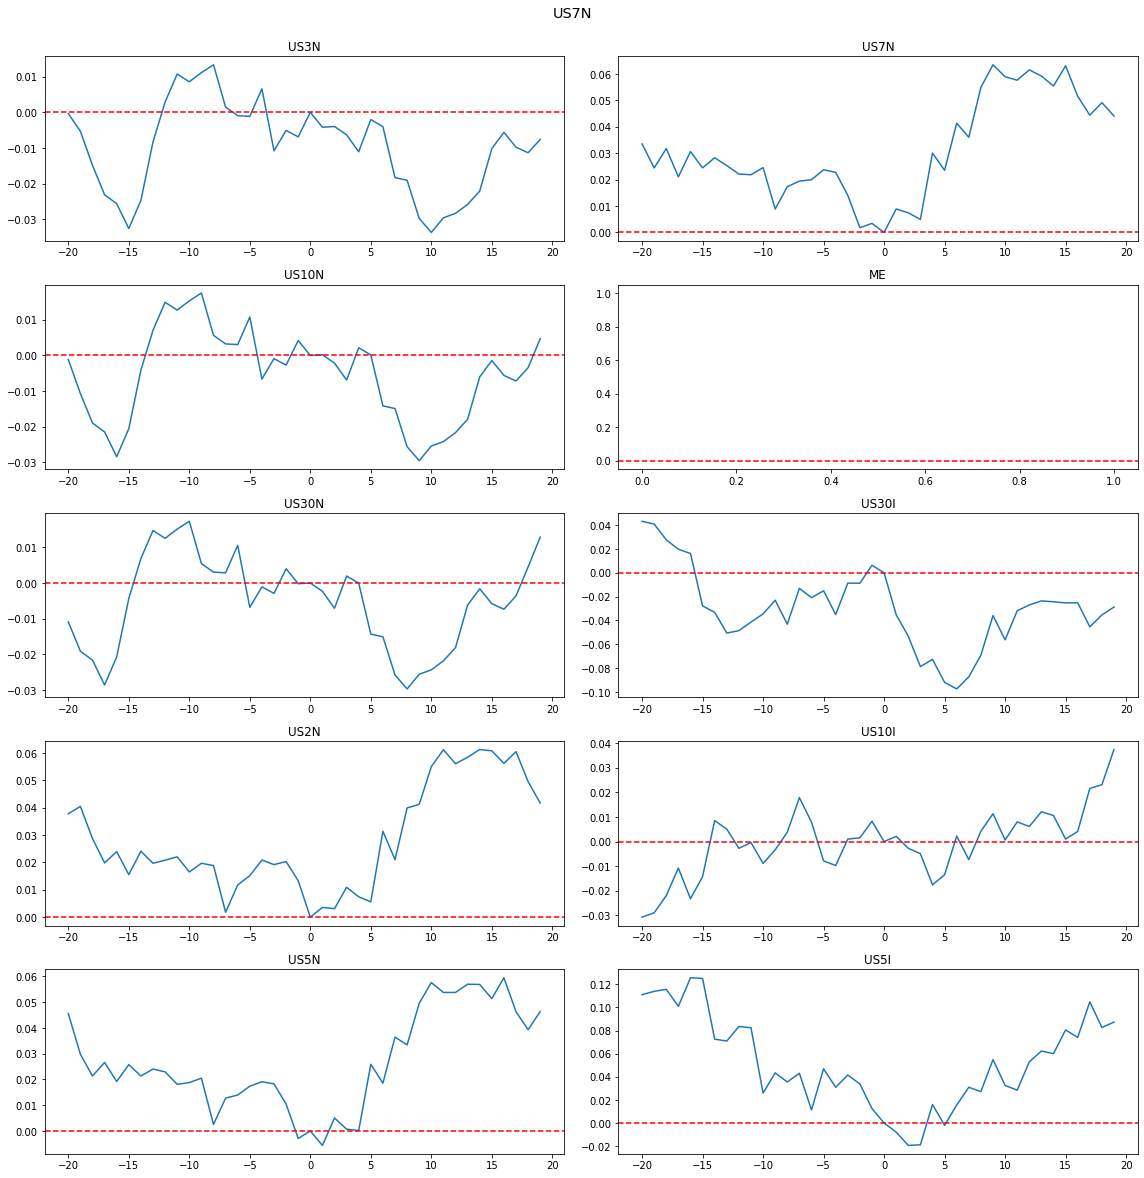

In [105]:
ticker = 'US7N'

evts=events.set_index('adate').drop('ayld', axis=1)
in_sample_end = px.index[-1]
in_sample_start = px[px.index>=dt.datetime(2014,1,1)].index[0]
print(in_sample_start)
srs = px.loc[:in_sample_end, ticker].dropna()
evts = evts[(evts.index <= in_sample_end) & (evts.index >= srs.index[0])]
def plot_event_horizons(srs, evts, window_size):
    """
        Plot average price action around events
    
    :param srs: (pd.Series) security prices timeseries
    :param evts: (pd.DataFrame) events series
    :param window_size: (int) size of window to show price action prior to and post event day
    """
    
    event_horizon = np.arange(-window_size,window_size)
    event_px_arr = []
    unique_events = evts['ticker'].unique()
    nrows = int(np.ceil(len(unique_events)/2))
    
    fig, ax = plt.subplots(figsize=(16,16), nrows=int(nrows), ncols=2)
    for i,eid in enumerate(unique_events):
        col = int(np.floor(i/nrows))
        row = int(i%nrows)
        
        subevts = evts.loc[evts['ticker']==eid]
        for offset in event_horizon:
            subevts[offset] = srs.shift(-offset).fillna(method='ffill') - srs
        
        subevts.dropna(how='any', inplace=True)
        ax[row][col].plot(subevts.loc[:, event_horizon].mean())
        ax[row][col].axhline(0, ls='--', c='r')
        ax[row][col].set_title(eid)
        event_px_arr.append(subevts)
    fig.suptitle(srs.name, fontsize='x-large', y=1.02)
    fig.tight_layout()
    plt.show()
    return 

plot_event_horizons(srs, evts[evts.index.month.isin([2,5,8,11])], 20)


## Backtest

### b. Event-driven
     Constant 1 cent per bp exposure at max position, no transaction cost, ignoring carry (for simplicity, to the 
     strategy's detriment since we are time-wgtd long duration and curve is on average positive)

In [8]:
def gen_event_driven(evt, px, entry, exit, size=1):
    """
        Generate events dataframe from event-driven strategy
        
    :param evt: (pd.Index) event datestamps
    :param px: (pd.Series) available close prices
    :param prior: (array[2] int) business days prior, side
    :param after: (array[2] int) business days post, side
    :return: (pd.DataFrame) 'events' dataframe: index=entry, t1=timeouts, side, size
    """
    # unpack inputs
    
    # have to shift event 1 day forward because of how we define the pnl series
    # in other words, we want to align our position entered at the close at idx t with the return at t+1 (r_t+1 = r_t+1 - r_t)
    # think i busted this
    evt = pd.Series(evt+BDay(1))
    days_prior, side_prior = entry
    days_after, side_after = exit
    
    first_date = min(px.index)
    max_date = max(px.index)
    
    evt = evt[((evt-days_prior)>=first_date) & ((evt+days_after)<=max_date)]
    print(evt)
    first_trade = [[max(e-days_prior, first_date), e, side_prior, size] for e in evt.values]
    second_trade = [[e, min(e+days_after, max_date), side_after, size] for e in evt.values]

    start_trade = pd.DataFrame(first_trade, columns=['dtidx','t1','side','size'])
    event_trade = pd.DataFrame(second_trade, columns=['dtidx','t1','side','size'])

    events = pd.concat([start_trade, event_trade], ignore_index=True, sort=True).set_index('dtidx').sort_index()
    return events


def gen_event_entryexit(evt, px, master_index, size=1):
    """
        Generate events dataframe and 'close' prices from event-driven strategy that pre-defines entry and exit dates 
            and replaces close prices with 'executions' where required (i.e. auction yield)
    :param evt: (pd.DataFrame) event yields (auction) and event close dates (monthend) indexed by event datestamps (auctions)
    :param px: (pd.Series) available close prices
    :return: (pd.DataFrame, pd.Series) 'events' dataframe: index=entry, t1=exit, side, size
    """
    # use master_index.searchsorted() on each of the dates, then do integer differences!
    evt = evt.copy()
    
    

In [107]:
series_names = ['US2N','US5N','US7N']
subevts = events[(events['ticker'].isin(series_names)) & (events['adate']<=in_sample_end) & (events['adate']>=in_sample_start)
                 & (events['adate'].dt.month.isin([2,5,8,11]))]
srs = px_raw[(px_raw['date']<=in_sample_end) & (px_raw['date']>=in_sample_start)
             & px_raw['ticker'].isin(series_names)] #in-sample series to analyze
srs = srs.set_index(['ticker','date'])
srs.head()

,,bbgyld
ticker,date,
US2N,2014-01-02,0.382
US5N,2014-01-02,1.719
US7N,2014-01-02,2.415
US2N,2014-01-03,0.398
US5N,2014-01-03,1.734


## In Sample PnL 

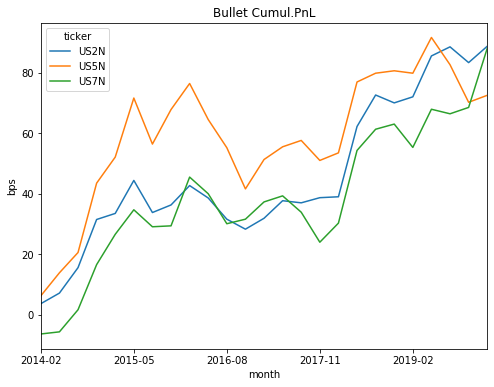

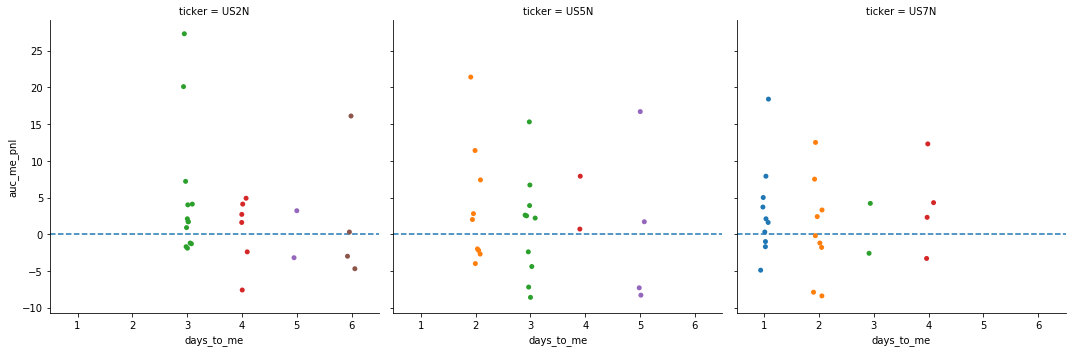

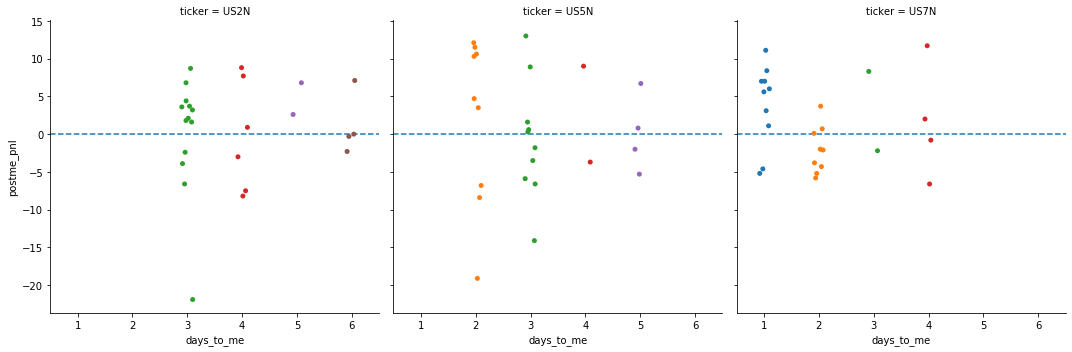

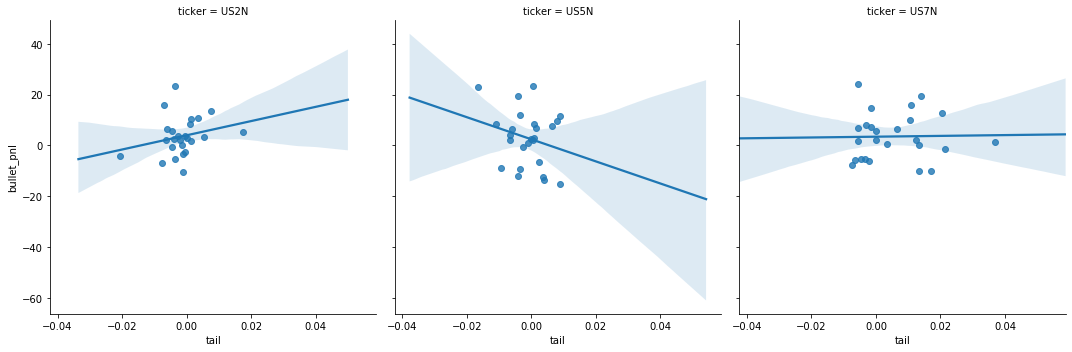

,adate,ayld,bid_to_cover,month,tail,ticker,adate_me,meyld,auc_me_pnl,master_idx,master_meidx,days_to_me,date_after_me,date,yld_after_me,postme_pnl,bullet_pnl,year,MoY
70,2019-11-26,1.587,2.50,2019-11,0.0035,US5N,2019-11-29,1.627,-4.0,3457,3459,2,2019-12-03,2019-12-03,1.543,-8.4,-12.4,2019,Nov
71,2019-11-27,1.719,2.44,2019-11,0.0125,US7N,2019-11-29,1.729,-1.0,3458,3459,1,2019-12-02,2019-12-02,1.760,3.1,2.1,2019,Nov
72,2020-02-25,1.188,2.45,2020-02,0.0175,US2N,2020-02-28,0.915,27.3,3517,3520,3,2020-03-04,2020-03-04,0.696,-21.9,5.4,2020,Feb
73,2020-02-26,1.150,2.46,2020-02,0.0005,US5N,2020-02-28,0.936,21.4,3518,3520,2,2020-03-03,2020-03-03,0.745,-19.1,2.3,2020,Feb
74,2020-02-27,1.247,2.49,2020-02,0.0140,US7N,2020-02-28,1.063,18.4,3519,3520,1,2020-03-02,2020-03-02,1.074,1.1,19.5,2020,Feb


In [138]:
# compute buy in auction, sell 2x monthend, cover x days later (x=me_date-auc_date)
subevts_me = subevts.merge(srs.reset_index().rename({'bbgyld': 'meyld', 'date': 'adate_me'}, axis=1), 
                           how='left', left_on=['adate_me','ticker'], right_on=['adate_me','ticker'])

subevts_me['auc_me_pnl'] = (subevts_me['ayld']-subevts_me['meyld'])*100
subevts_me['master_idx'] = master_index.searchsorted(subevts_me['adate'])
subevts_me['master_meidx'] = master_index.searchsorted(subevts_me['adate_me'])
subevts_me['days_to_me'] = subevts_me['master_meidx'] - subevts_me['master_idx']
subevts_me = subevts_me[~(subevts_me['days_to_me']>=10)]
subevts_me['date_after_me'] = master_index.loc[subevts_me['master_meidx']+subevts_me['days_to_me']].values

subevts_me = subevts_me.merge(srs.reset_index().rename({'bbgyld':'yld_after_me'}, axis=1),
                             how='left', left_on=['date_after_me','ticker'], right_on=['date','ticker'])
subevts_me['postme_pnl'] = (subevts_me['yld_after_me']-subevts_me['meyld'])*100
subevts_me['bullet_pnl'] = subevts_me['postme_pnl']+subevts_me['auc_me_pnl']
subevts_me['year'] = subevts_me['adate'].dt.year
subevts_me['MoY'] = subevts_me['adate'].dt.strftime("%b")
# plot cumulative pnl
fig, ax = plt.subplots(figsize=(8,6), nrows=1)
#subevts_me.groupby(['month','ticker']).sum()['auc_me_pnl'].unstack().cumsum().plot(ax=ax[0])
#subevts_me.groupby(['month','ticker']).sum()['postme_pnl'].unstack().cumsum().plot(ax=ax[1])
#ax[0].set_title('Auction to ME PnL')
#ax[1].set_title('Post ME PnL')

subevts_me.groupby(['month','ticker']).sum()['bullet_pnl'].unstack().cumsum().plot(ax=ax)
ax.set_title('Bullet Cumul.PnL')
ax.set_ylabel('bps')
#fig.tight_layout()

# plot scatter of auction to ME pnl and post ME pnl as function of BTC and tail

#sns.lmplot(x='bid_to_cover', y='auc_me_pnl', data=subevts_me)
#sns.lmplot(x='bid_to_cover', y='postme_pnl', data=subevts_me)
g1=sns.catplot(x='days_to_me', y='auc_me_pnl', col='ticker', data=subevts_me)
g2=sns.catplot(x='days_to_me', y='postme_pnl', col='ticker', data=subevts_me)#, col_wrap=2)
sns.lmplot(x='tail', y='bullet_pnl', col='ticker', data=subevts_me)
axs1=g1.axes[0]
axs2=g2.axes
for ax in np.hstack([axs1,axs2.flatten()]):
    ax.axhline(0, ls='--')

plt.show()
subevts_me.tail()

In [131]:
px_raw[(px_raw['ticker']=='US7N') & (px_raw['date']==dt.date(2020,2,28))]

,ticker,date,bbgyld
30998,US7N,2020-02-28,1.063


In [68]:

this_event = 'ME'


entry_setting = [5, -1]
event_setting = [5, 1]
in_sample_end = px.index[-int(px.shape[0]/5)] #dtidx of when in-sample period ends
event_desc = series_name+': \'short\' 5 days prior cover in event, get \'long\' at event, hold 7 days'

event_driven_events = gen_event_driven(evts[evts['ticker']==this_event].index, srs, entry_setting, event_setting)
event_summary, event_pnl_index = generate_perf_summary(event_driven_events, srs)
exposures = generate_exposures(event_driven_events, srs)

fig, ax = plt.subplots(figsize=(8,8), nrows=2)
event_pnl_index.plot(ax=ax[0])
ax[0].legend(['Initial $1 Capital'])
ax[0].set_title('In-Sample PnL: '+event_desc)
exposures.iloc[1250:1400].plot(ax=ax[1])
ax[1].set_title('Initial exposures snapshot')
fig.suptitle(this_event,y=1.02)
fig.tight_layout()
plt.show()
print('Time Wgtd Avg Position:', np.round(exposures.mean(),3))
print('Time Wgtd Avg Gross Position:', np.round(abs(exposures).mean(),3))
print('$ Units Below')
event_summary

0     2009-02-02 19:00:00-05:00
1     2009-03-02 19:00:00-05:00
2     2009-03-31 20:00:00-04:00
3     2009-04-30 20:00:00-04:00
4     2009-06-01 20:00:00-04:00
5     2009-06-30 20:00:00-04:00
6     2009-07-31 20:00:00-04:00
7     2009-08-31 20:00:00-04:00
8     2009-09-30 20:00:00-04:00
9     2009-11-02 20:00:00-05:00
10    2009-11-30 19:00:00-05:00
11    2009-12-31 19:00:00-05:00
12    2010-02-01 19:00:00-05:00
13    2010-03-01 19:00:00-05:00
14    2010-03-31 20:00:00-04:00
15    2010-04-30 20:00:00-04:00
16    2010-05-31 20:00:00-04:00
17    2010-06-30 20:00:00-04:00
18    2010-08-02 20:00:00-04:00
19    2010-08-31 20:00:00-04:00
20    2010-09-30 20:00:00-04:00
21    2010-11-01 20:00:00-04:00
22    2010-11-30 19:00:00-05:00
23    2010-12-31 19:00:00-05:00
24    2011-01-31 19:00:00-05:00
25    2011-02-28 19:00:00-05:00
26    2011-03-31 20:00:00-04:00
27    2011-05-02 20:00:00-04:00
28    2011-05-31 20:00:00-04:00
29    2011-06-30 20:00:00-04:00
                 ...           
71    20

TypeError: ufunc subtract cannot use operands with types dtype('<M8[ns]') and dtype('O')

## Backtest

### Out-of-sample
    We decide to evaluate out-of-sample our best performing strategy parameters chosen over the in-sample period, again
        constant 1 cent per bp risk:
    a. Momentum: 60d lookback (normalized for trailing vol) held for 20d (non-normalized), evaluated daily. Position 
        rebalanced daily to the average 'live' signal on each day
    b. Event-based:
      i. Sec_4: Long the 'price' 7d prior to event_4, sell long and enter short on event day close, cover short 12d after
      ii. Sec_4: Short the 'price' 5d prior to event_10, cover short and enter long on event day close, close long 7d after
    c. Combination: based on the in-sample IRs, size momentum at 1/4, event_4 at 1, event_10 at 1/2

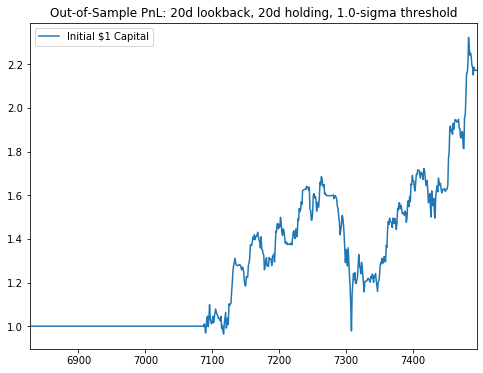

Time Wgtd Avg Position: 0.276
Time Wgtd Gross Position: 0.871
$ Units Below


Ann. Ret.           0.723843
Ann. Vol.           0.447550
IR                  1.617344
Calmar              1.024443
Max Drawdown       -0.706572
# Trades          174.000000
Avg. Daily PnL      0.001754
dtype: float64

In [17]:
zscore_lookback = 120 #rolling window size to generate uncentered zscores
#dtidx of when out-of-sample period starts, we allow for some overlap to calc trailing vol
oos_start = in_sample_end+1-zscore_lookback 
lookbacks = [20] #return frequencies
z_threshold = 1.0 #zscore threshold for signal generation, 0 for simplicity otherwise we have complexities arising from overlaps

v = 20 #holding period
series_name = 'sec_3'
strategy_desc = "{0}d lookback, {1}d holding, {2}-sigma threshold".format(lookbacks[0], v, z_threshold)
srs_oos = px.loc[oos_start:, series_name] #in-sample series to analyze

signals_oos, zscores_oos = gen_mom_signals(srs_oos, z_threshold=z_threshold, lookbacks=lookbacks, zscore_lookback=zscore_lookback,
                                          signal_type='Reversion', center=True)
signal_oos = signals_oos.loc[:, lookbacks[0]].shift(1).dropna() #pnl will assume we can enter position at same close px of signal generation
avg_position_oos, mom_events_oos = get_pat_events(srs_oos, signal_oos, v)

mom_summary_oos, mom_pnl_index_oos = generate_perf_summary(mom_events_oos, srs_oos)
fig, ax = plt.subplots(figsize=(8,6))
mom_pnl_index_oos.plot(ax=ax)
ax.legend(['Initial $1 Capital'])
ax.set_title('Out-of-Sample PnL: '+strategy_desc)
plt.show()
print('Time Wgtd Avg Position:', np.round(avg_position_oos['position'].mean(),3))
print('Time Wgtd Gross Position:', np.round(abs(avg_position_oos['position']).mean(),3))
print('$ Units Below')
mom_summary_oos

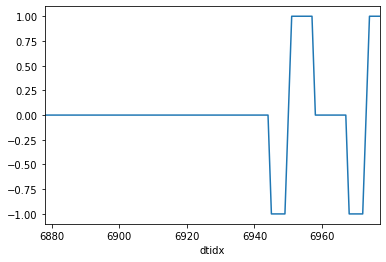

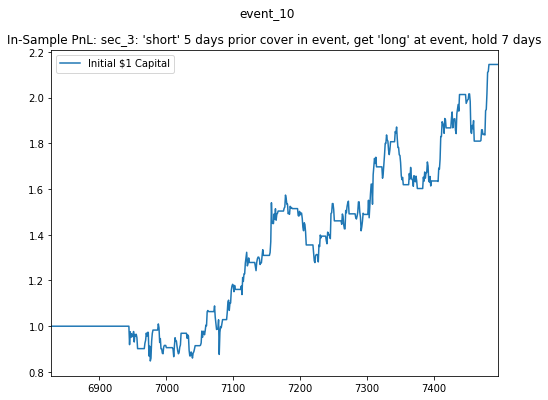

Time Wgtd Avg Position: 0.078
Time Wgtd Avg Gross Position: 0.467
$ Units Below


Ann. Ret.          0.524664
Ann. Vol.          0.428199
IR                 1.225281
Calmar             1.776114
Max Drawdown      -0.295400
# Trades          52.000000
Avg. Daily PnL     0.001714
dtype: float64

In [20]:
this_event = 'event_10'
oos_start = in_sample_end+1
evts_oos=events.set_index('dtidx')
evts_oos=evts_oos[evts_oos.index!=12601]
evts_oos = evts_oos[evts_oos.index >= oos_start]
entry_setting = [5, -1]
event_setting = [7, 1]
event_desc = series_name+': \'short\' 5 days prior cover in event, get \'long\' at event, hold 7 days'

event_driven_events_oos = gen_event_driven(evts_oos[evts_oos['eid']==this_event].index, srs_oos, entry_setting, event_setting)
event_summary_oos, event_pnl_index_oos = generate_perf_summary(event_driven_events_oos, srs_oos)

fig, ax = plt.subplots()
exposures_oos = generate_exposures(event_driven_events_oos, srs_oos)
exposures_oos.iloc[50:150].plot(ax=ax)

plt.show()

fig, ax = plt.subplots(figsize=(8,6))
event_pnl_index_oos.plot(ax=ax)
ax.legend(['Initial $1 Capital'])
ax.set_title('In-Sample PnL: '+event_desc)
fig.suptitle(this_event)
plt.show()
print('Time Wgtd Avg Position:', np.round(exposures_oos.mean(),3))
print('Time Wgtd Avg Gross Position:', np.round(abs(exposures_oos).mean(),3))
print('$ Units Below')
event_summary_oos

In [19]:
# combine strategies with weights
def generate_comb_perf_summary(pnl_indexes, weights):
    """
    Function to generate CAGR, vol, sharpe, calmar, max drawdown, # trades, avg pnl per trade, hit ratio
    
    :input pnl_indexes: (1d-array) array of series of pnl indexes
    :input weights: (np.array) weights assigned to pnl indexes
    :return: (pd.DataFrame) summary of pnl attributes
    """
    merge_pnl = pd.concat(pnl_indexes, axis=1)
    pnl_index = merge_pnl.dot(weights/sum(weights))
    first_date = min([pnl_index.index[0] for pnl_index in pnl_indexes])
    last_date = max([pnl_index.index[-1] for pnl_index in pnl_indexes])
    years_live = (last_date-first_date)/252
    # since it's constant exposure, use simple average
    #cagr = np.power(pnl_index.iloc[-1]/pnl_index.iloc[0],1/years_live)-1.
    avg_ret = (pnl_index.iloc[-1]/pnl_index.iloc[0]-1)/years_live
    returns = pnl_index.diff(1).dropna()
    vol = returns.std()
    # assumes daily close data
    annualized_vol = vol*np.sqrt(252)
    sharpe = avg_ret/annualized_vol
    drawdown_pnl = pnl_index.subtract(pnl_index.expanding(0).max())
    max_dd = np.min(drawdown_pnl)
    calmar = -avg_ret/max_dd
    
    avg_pnl = pnl_index.diff(1).dropna(0).mean()
    
    summary = pd.Series([avg_ret,annualized_vol,sharpe,calmar, max_dd, avg_pnl], 
                       index=['Ann. Ret.','Ann. Vol.','IR','Calmar','Max Drawdown','Avg. Daily PnL'])
    return summary, pnl_index



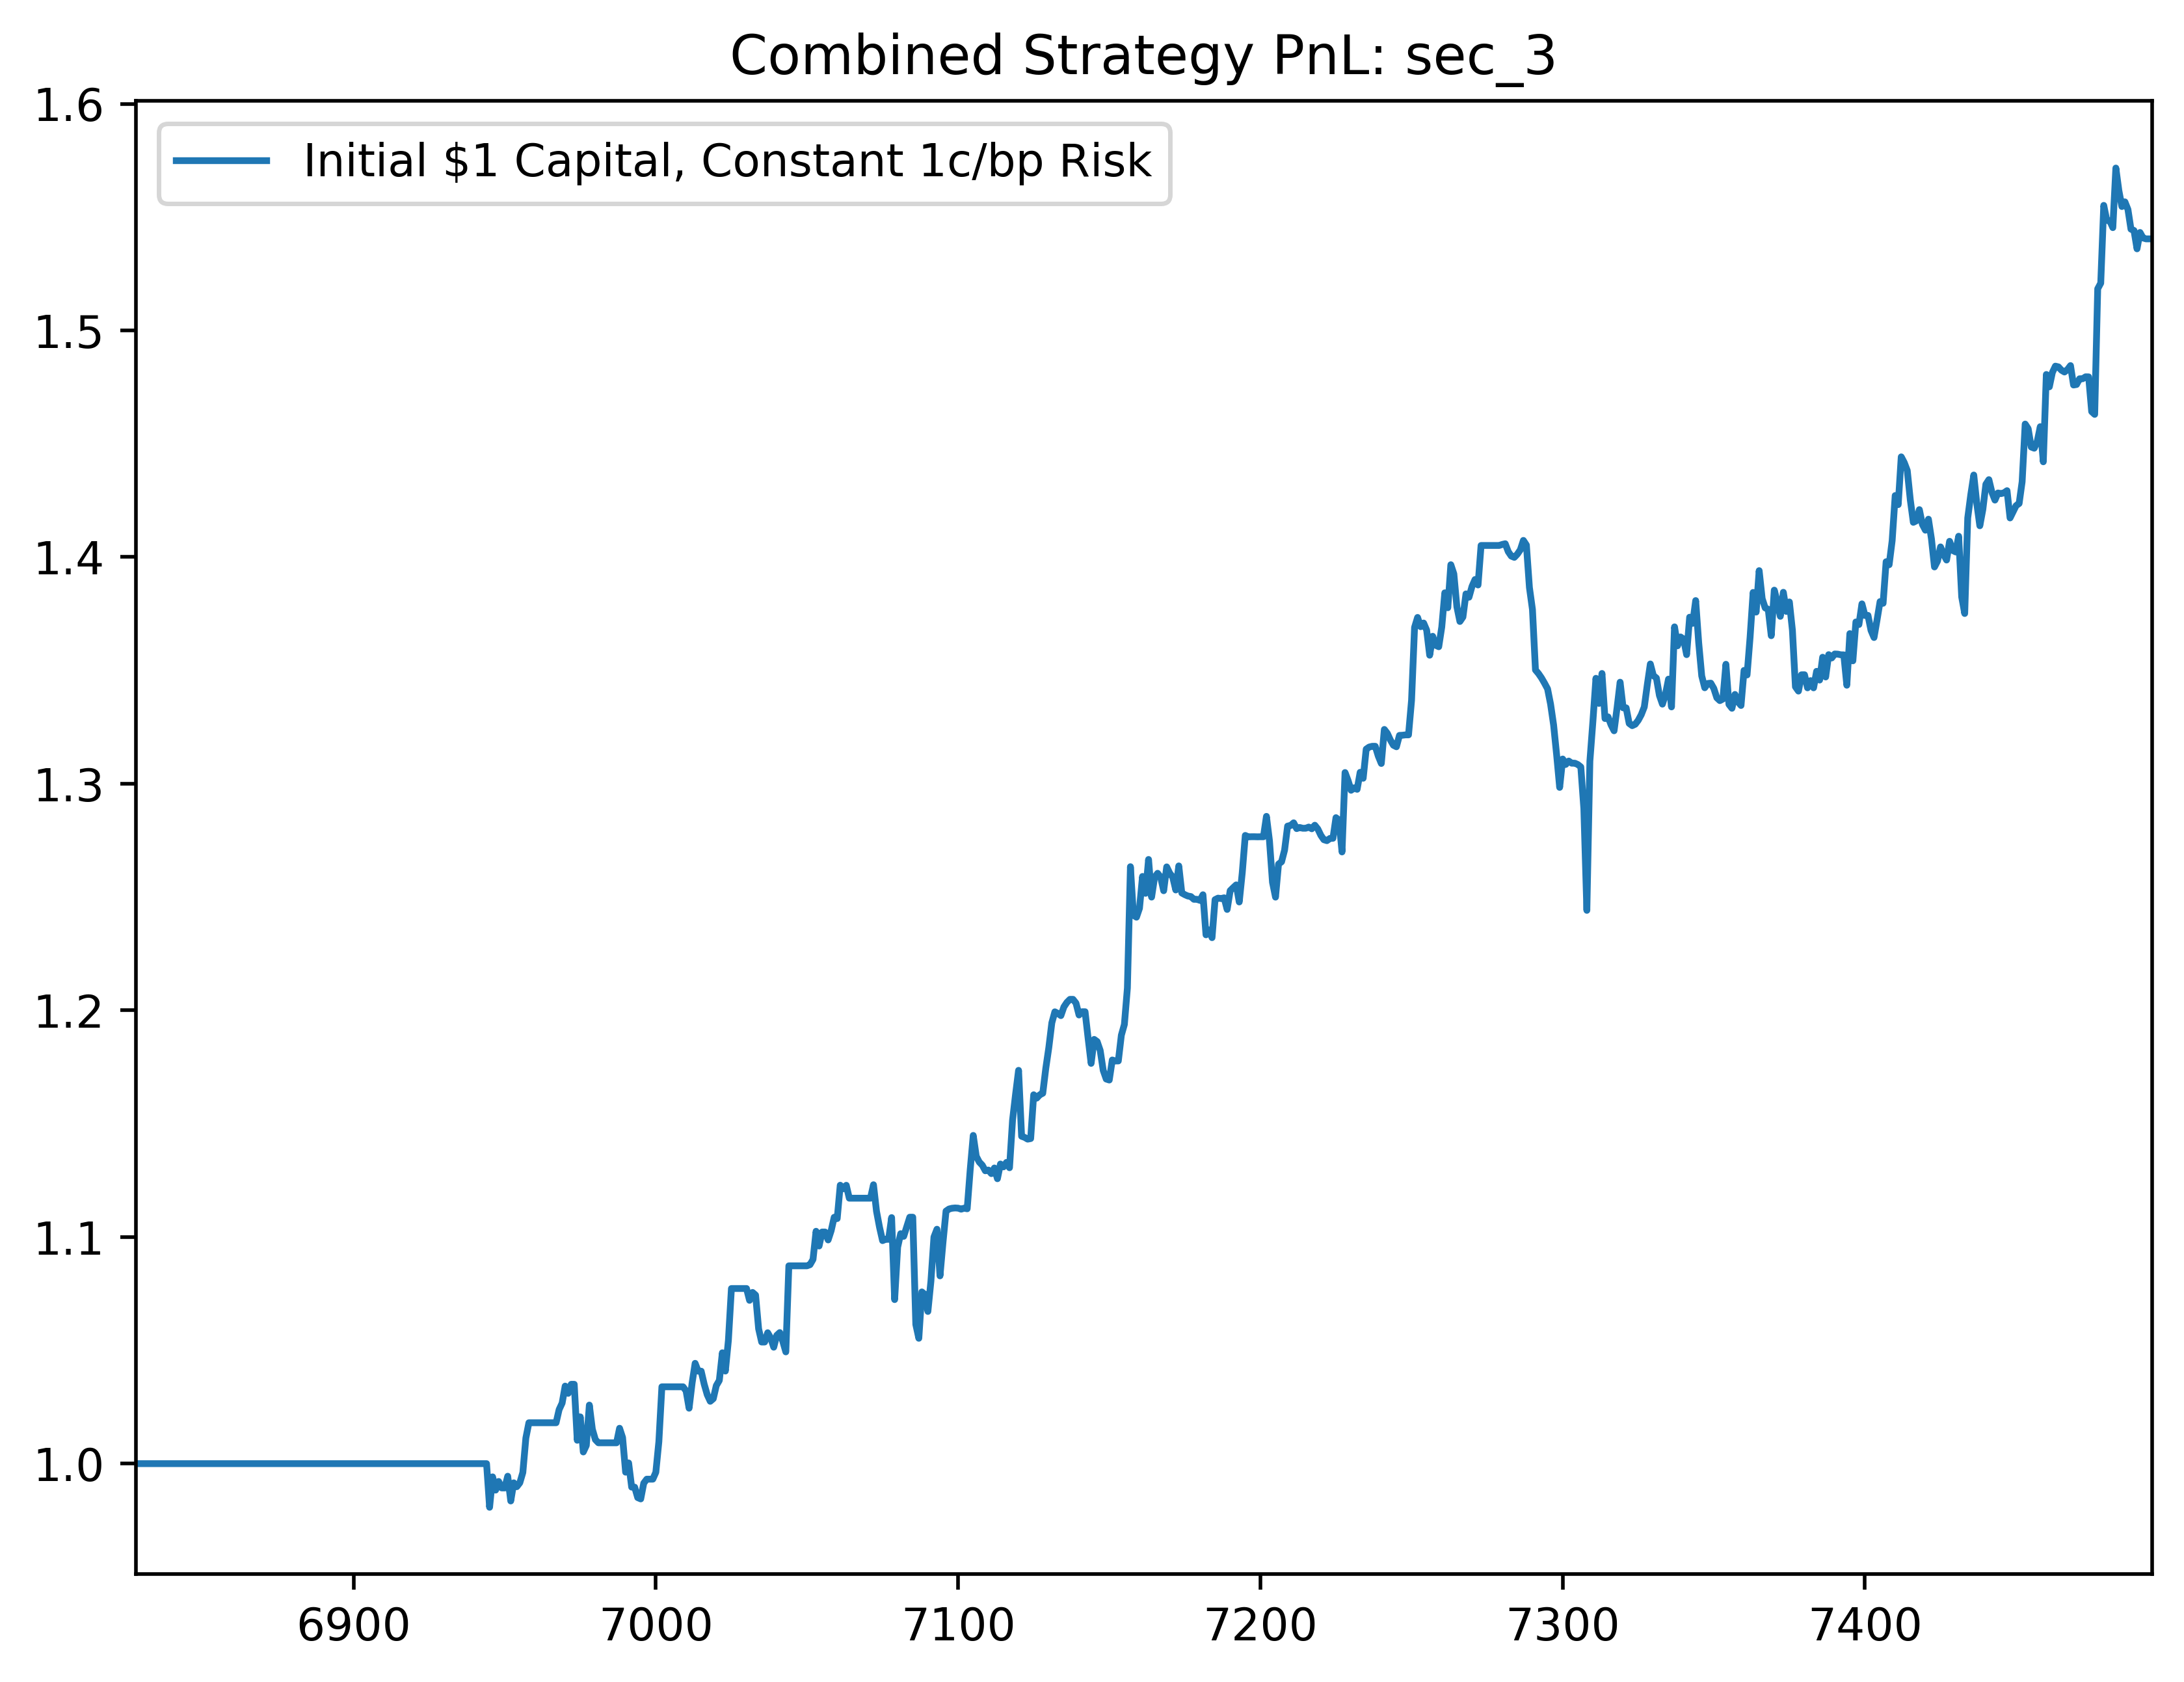

sec_3


Ann. Ret.         0.2042
Ann. Vol.         0.1533
IR                1.3316
Calmar            1.2508
Max Drawdown     -0.1632
Avg. Daily PnL    0.0008
dtype: float64

In [23]:
oos_start = in_sample_end+1
evts_oos=events.set_index('dtidx')
evts_oos=evts_oos[evts_oos.index!=12601]
evts_oos = evts_oos[evts_oos.index >= oos_start]

event_8_oos = gen_event_driven(evts_oos[evts_oos['eid']=='event_8'].index, srs_oos, (2,-1), (5,0))
event_10_oos = gen_event_driven(evts_oos[evts_oos['eid']=='event_10'].index, srs_oos, (5,-1), (7,1))
event_summary_oos_8, event_pnl_index_oos_8 = generate_perf_summary(event_8_oos, srs_oos)
event_summary_oos_10, event_pnl_index_oos_10 = generate_perf_summary(event_10_oos, srs_oos)
strategies_pnl = [mom_pnl_index_oos, event_pnl_index_oos_8, event_pnl_index_oos_10]
weights = np.array([0.6, 1.6, 0.69])
summary, combined_pnl_index = generate_comb_perf_summary(strategies_pnl, weights)


fig, ax = plt.subplots(figsize=(8,6), dpi=500)
combined_pnl_index.plot(ax=ax)
ax.set_title('Combined Strategy PnL: '+ series_name)
ax.legend(['Initial $1 Capital, Constant 1c/bp Risk'])
plt.show()
print(series_name)
summary.round(4)